## Distribution-free Tolerance Intervals

Import libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpltlb
import scipy.stats as st

Import my own python code to calculate distribution free intervals

In [3]:
from dist_free_intrvls import *

Definitions

In [33]:
nice_purple = [95/256, 75/256, 139/256]
mpltlb.rcParams.update({'font.size': 16})

### Example: Estimating the time taken to complete a task

In [151]:
k = 2
lmbd = 7
n_samples = 5000
erlang_samp = st.erlang.rvs(size = n_samples , a= k, scale = lmbd)

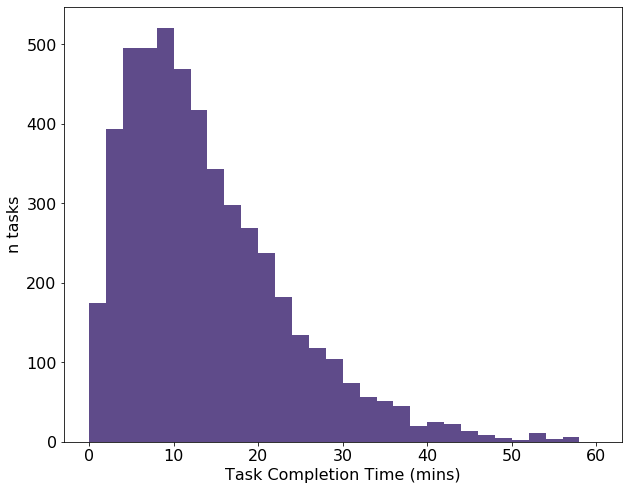

In [152]:
xmax = 60
binstep = 2

x = np.arange(0, xmax, 0.001)
y = st.erlang.pdf(x, a= k, scale = lmbd)
fig, ax = plt.subplots(figsize = [10,8])
ax.hist(erlang_samp, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
#ax.plot(x,y, color = [0.8, 0.8, 0.8])
ax.set_xlabel('Task Completion Time (mins)')
ax.set_ylabel('n tasks')
plt.savefig('images/task_completion_time_n_eq_{}.png'.format(n_samples), bbox_inches = 'tight', dpi = 600)
plt.show()

### Task completion statistic

In [153]:
np.mean(erlang_samp)

13.973729753290263

In [154]:
np.std(erlang_samp)

9.670459034789898

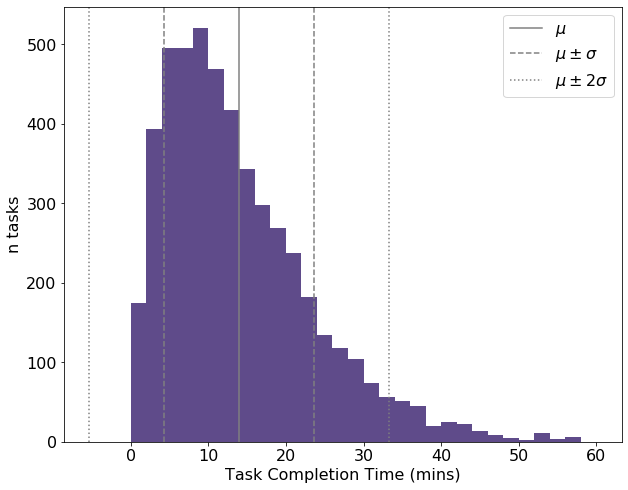

In [179]:
xmax = 60
binstep = 2

x = np.arange(0, xmax, 0.001)
y = st.erlang.pdf(x, a= k, scale = lmbd)
fig, ax = plt.subplots(figsize = [10,8])
ax.hist(erlang_samp, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
#ax.plot(x,y, color = [0.8, 0.8, 0.8])
currylim = ax.get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax.plot(np.mean(erlang_samp)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '$\mu$')
ax.plot(np.mean(erlang_samp)+np.std(erlang_samp)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '$\mu \pm \sigma$')
ax.plot(np.mean(erlang_samp)-np.std(erlang_samp)+0*y_arr, y_arr, '--', color = [0.5, 0.5, 0.5])
ax.plot(np.mean(erlang_samp)+2*np.std(erlang_samp)+0*y_arr, y_arr, ':',color = [0.5, 0.5, 0.5], label = '$\mu \pm 2\sigma$')
ax.plot(np.mean(erlang_samp)-2*np.std(erlang_samp)+0*y_arr, y_arr, ':', color = [0.5, 0.5, 0.5])
ax.set_ylim(currylim)
ax.legend()
ax.set_xlabel('Task Completion Time (mins)')
ax.set_ylabel('n tasks')
plt.savefig('images/task_completion_time_n_eq_{}_withmean.png'.format(n_samples), bbox_inches = 'tight', dpi = 600)
plt.show()

### Summary statistics for non-normal distributions

In [156]:
n_samples = 5000
norm_samp = st.norm.rvs(size = n_samples)

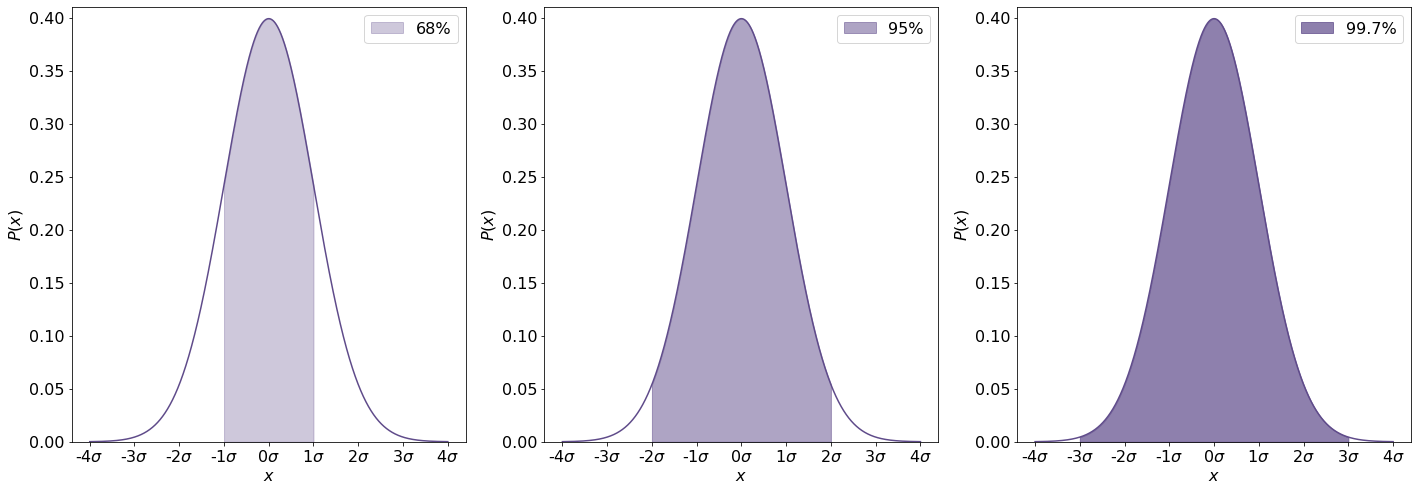

In [157]:
xmax = 4
binstep = 0.2

x = np.arange(-xmax, xmax+0.001, 0.001)
y = st.norm.pdf(x)
fig, ax = plt.subplots(1,3, figsize = [24,8])
ax[0].plot(x,y, color = nice_purple)
mask = (x>=-1)&(x<=1)
ax[0].fill_between(x[mask],y[mask], color = nice_purple, alpha = 0.3, label = '68%')
ax[0].set_xticks(np.arange(-xmax, xmax+1,1))
ax[0].set_xticklabels([str(x)+'$\sigma$' for x in np.arange(-xmax, xmax+1,1)])
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$P(x)$')
ax[0].legend()
ax[0].set_ylim([0,0.41])

ax[1].plot(x,y, color = nice_purple)
mask = (x>=-2)&(x<=2)
ax[1].fill_between(x[mask],y[mask], color = nice_purple, alpha = 0.5, label = '95%')
ax[1].set_xticks(np.arange(-xmax, xmax+1,1))
ax[1].set_xticklabels([str(x)+'$\sigma$' for x in np.arange(-xmax, xmax+1,1)])
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$P(x)$')
ax[1].legend()
ax[1].set_ylim([0,0.41])

ax[2].plot(x,y, color = nice_purple)
mask = (x>=-3)&(x<=3)
ax[2].fill_between(x[mask],y[mask], color = nice_purple, alpha = 0.7, label = '99.7%')
ax[2].set_xticks(np.arange(-xmax, xmax+1,1))
ax[2].set_xticklabels([str(x)+'$\sigma$' for x in np.arange(-xmax, xmax+1,1)])
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$P(x)$')
ax[2].legend()
ax[2].set_ylim([0,0.41])


plt.savefig('images/normal_distribution.png'.format(n_samples), bbox_inches = 'tight', dpi = 600)
plt.show()

### Task completion statistic revisited

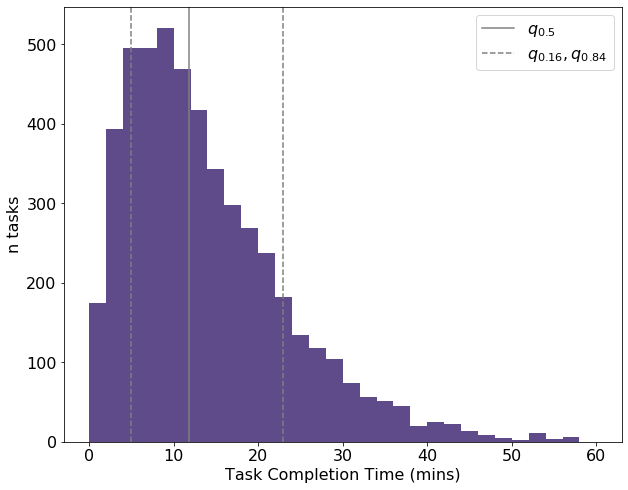

In [163]:
xmax = 60
binstep = 2

x = np.arange(0, xmax, 0.001)
y = st.erlang.pdf(x, a= k, scale = lmbd)
fig, ax = plt.subplots(figsize = [10,8])
ax.hist(erlang_samp, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
#ax.plot(x,y, color = [0.8, 0.8, 0.8])
currylim = ax.get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax.plot(np.quantile(erlang_samp, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '$q_{0.5}$')
ax.plot(np.quantile(erlang_samp, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '$q_{0.16}, q_{0.84}$')
ax.plot(np.quantile(erlang_samp, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
# ax.plot(np.mean(erlang_samp)+np.std(erlang_samp)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '$\mu \pm \sigma$')
# ax.plot(np.mean(erlang_samp)-np.std(erlang_samp)+0*y_arr, y_arr, '--', color = [0.5, 0.5, 0.5])
ax.set_ylim(currylim)
ax.legend()
ax.set_xlabel('Task Completion Time (mins)')
ax.set_ylabel('n tasks')
plt.savefig('images/task_completion_time_n_eq_{}_witinterval.png'.format(n_samples), bbox_inches = 'tight', dpi = 600)
plt.show()

In [158]:
st.erlang.ppf(0.5, a= k, scale = lmbd)

11.748428930116628

In [159]:
np.quantile(erlang_samp, 0.16)

5.003311616158726

In [160]:
np.quantile(erlang_samp, 0.84)

22.982025539558638

### Less Data

In [161]:
k = 2
lmbd = 7
n_samples_red = 50

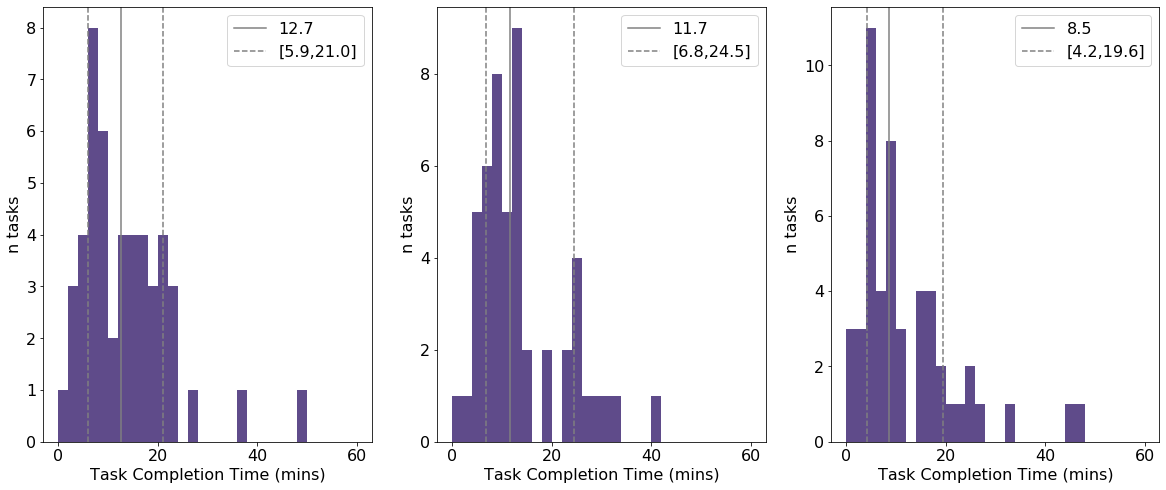

In [204]:
xmax = 60
binstep = 2

# forgive lack of for loop, in massive rush

fig, ax = plt.subplots(1,3,figsize = [20,8])

erlang_samp_red = st.erlang.rvs(size = n_samples_red , a= k, scale = lmbd)
ax[0].hist(erlang_samp_red, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
currylim = ax[0].get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax[0].plot(np.quantile(erlang_samp_red, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '{:.1f}'.format(np.quantile(erlang_samp_red, 0.5)))
ax[0].plot(np.quantile(erlang_samp_red, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '[{:.1f},{:.1f}]'.format(np.quantile(erlang_samp_red, 0.16),np.quantile(erlang_samp_red, 0.84)))
ax[0].plot(np.quantile(erlang_samp_red, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
ax[0].set_ylim(currylim)
ax[0].legend()
ax[0].set_xlabel('Task Completion Time (mins)')
ax[0].set_ylabel('n tasks')

erlang_samp_red = st.erlang.rvs(size = n_samples_red , a= k, scale = lmbd)
ax[1].hist(erlang_samp_red, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
currylim = ax[1].get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax[1].plot(np.quantile(erlang_samp_red, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '{:.1f}'.format(np.quantile(erlang_samp_red, 0.5)))
ax[1].plot(np.quantile(erlang_samp_red, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '[{:.1f},{:.1f}]'.format(np.quantile(erlang_samp_red, 0.16),np.quantile(erlang_samp_red, 0.84)))
ax[1].plot(np.quantile(erlang_samp_red, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
ax[1].set_ylim(currylim)
ax[1].legend()
ax[1].set_xlabel('Task Completion Time (mins)')
ax[1].set_ylabel('n tasks')

erlang_samp_red = st.erlang.rvs(size = n_samples_red , a= k, scale = lmbd)
ax[2].hist(erlang_samp_red, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
currylim = ax[2].get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax[2].plot(np.quantile(erlang_samp_red, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '{:.1f}'.format(np.quantile(erlang_samp_red, 0.5)))
ax[2].plot(np.quantile(erlang_samp_red, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '[{:.1f},{:.1f}]'.format(np.quantile(erlang_samp_red, 0.16),np.quantile(erlang_samp_red, 0.84)))
ax[2].plot(np.quantile(erlang_samp_red, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
ax[2].set_ylim(currylim)
ax[2].legend()
ax[2].set_xlabel('Task Completion Time (mins)')
ax[2].set_ylabel('n tasks')

plt.savefig('images/task_completion_time_n_eq_{}_witinterval.png'.format(n_samples_red), bbox_inches = 'tight', dpi = 600)
plt.show()

In [147]:
np.quantile(erlang_samp_red, 0.16)

6.375436835513229

In [148]:
np.quantile(erlang_samp_red, 0.84)

23.358486124003655

### Let's calculate some Tolerance Intervals

In [183]:
beta = 0.68
oneminalpha = 0.95
two_sided_int = two_sided_interp_tol_intrvls(beta, erlang_samp, oneminalpha)

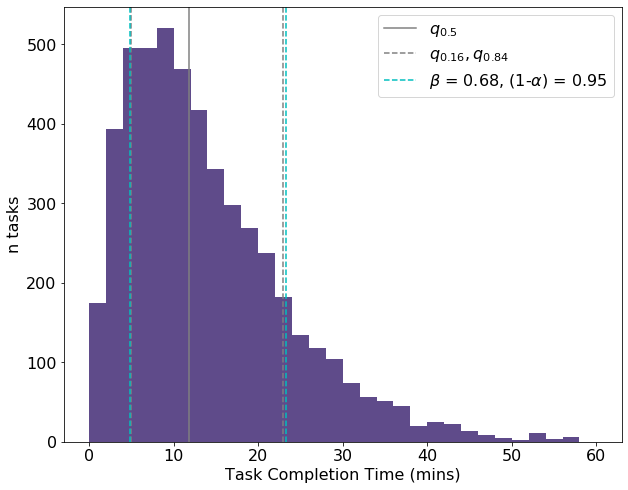

In [197]:
xmax = 60
binstep = 2

x = np.arange(0, xmax, 0.001)
y = st.erlang.pdf(x, a= k, scale = lmbd)
fig, ax = plt.subplots(figsize = [10,8])
ax.hist(erlang_samp, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
#ax.plot(x,y, color = [0.8, 0.8, 0.8])
currylim = ax.get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax.plot(np.quantile(erlang_samp, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '$q_{0.5}$')
ax.plot(np.quantile(erlang_samp, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '$q_{0.16}, q_{0.84}$')
ax.plot(np.quantile(erlang_samp, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
ax.plot(two_sided_int[0]+0*y_arr, y_arr, '--',color = 'c', label = r'$\beta$ = {:.2f}, (1-$\alpha$) = {:.2f}'.format(beta,oneminalpha))
ax.plot(two_sided_int[1]+0*y_arr, y_arr, '--',color = 'c')
ax.set_ylim(currylim)
ax.legend()
ax.set_xlabel('Task Completion Time (mins)')
ax.set_ylabel('n tasks')
plt.savefig('images/task_completion_time_n_eq_{}_with_tol_int.png'.format(n_samples), bbox_inches = 'tight', dpi = 600)
plt.show()

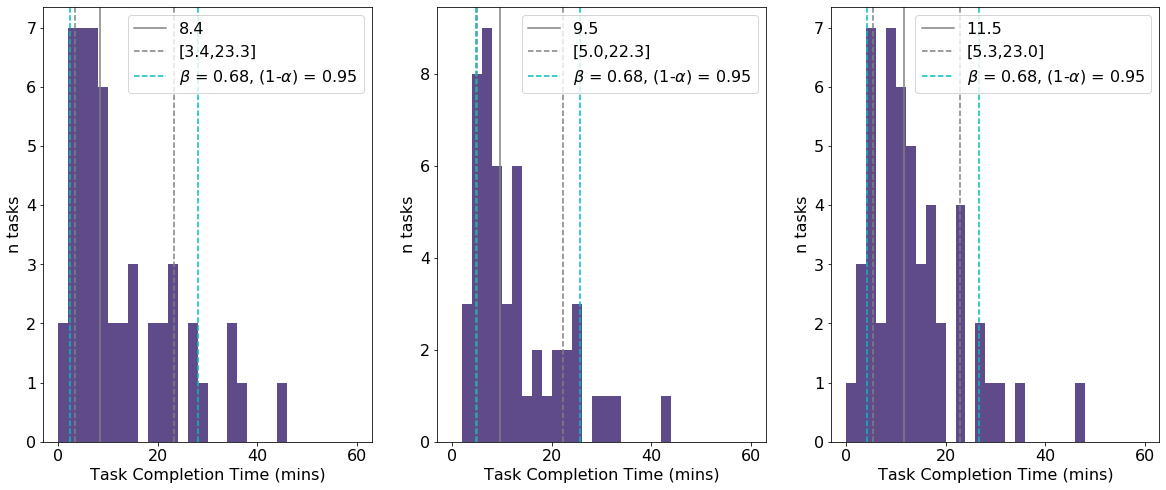

In [203]:
xmax = 60
binstep = 2

# forgive lack of for loop, in massive rush

fig, ax = plt.subplots(1,3,figsize = [20,8])

erlang_samp_red = st.erlang.rvs(size = n_samples_red , a= k, scale = lmbd)
two_sided_int_red = two_sided_interp_tol_intrvls(beta, erlang_samp_red, oneminalpha)
ax[0].hist(erlang_samp_red, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
currylim = ax[0].get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax[0].plot(np.quantile(erlang_samp_red, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '{:.1f}'.format(np.quantile(erlang_samp_red, 0.5)))
ax[0].plot(np.quantile(erlang_samp_red, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '[{:.1f},{:.1f}]'.format(np.quantile(erlang_samp_red, 0.16),np.quantile(erlang_samp_red, 0.84)))
ax[0].plot(np.quantile(erlang_samp_red, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
ax[0].plot(two_sided_int_red[0]+0*y_arr, y_arr, '--',color = 'c', label = r'$\beta$ = {:.2f}, (1-$\alpha$) = {:.2f}'.format(beta,oneminalpha))
ax[0].plot(two_sided_int_red[1]+0*y_arr, y_arr, '--',color = 'c')
ax[0].set_ylim(currylim)
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('Task Completion Time (mins)')
ax[0].set_ylabel('n tasks')

erlang_samp_red = st.erlang.rvs(size = n_samples_red , a= k, scale = lmbd)
two_sided_int_red = two_sided_interp_tol_intrvls(beta, erlang_samp_red, oneminalpha)
ax[1].hist(erlang_samp_red, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
currylim = ax[1].get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax[1].plot(np.quantile(erlang_samp_red, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '{:.1f}'.format(np.quantile(erlang_samp_red, 0.5)))
ax[1].plot(np.quantile(erlang_samp_red, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '[{:.1f},{:.1f}]'.format(np.quantile(erlang_samp_red, 0.16),np.quantile(erlang_samp_red, 0.84)))
ax[1].plot(np.quantile(erlang_samp_red, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
ax[1].plot(two_sided_int_red[0]+0*y_arr, y_arr, '--',color = 'c', label = r'$\beta$ = {:.2f}, (1-$\alpha$) = {:.2f}'.format(beta,oneminalpha))
ax[1].plot(two_sided_int_red[1]+0*y_arr, y_arr, '--',color = 'c')
ax[1].set_ylim(currylim)
ax[1].legend()
ax[1].set_xlabel('Task Completion Time (mins)')
ax[1].set_ylabel('n tasks')

erlang_samp_red = st.erlang.rvs(size = n_samples_red , a= k, scale = lmbd)
two_sided_int_red = two_sided_interp_tol_intrvls(beta, erlang_samp_red, oneminalpha)
ax[2].hist(erlang_samp_red, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
currylim = ax[2].get_ylim()
y_arr = np.arange(0,currylim[1]+100, 1)
ax[2].plot(np.quantile(erlang_samp_red, 0.5)+0*y_arr, y_arr, color = [0.5, 0.5, 0.5], label = '{:.1f}'.format(np.quantile(erlang_samp_red, 0.5)))
ax[2].plot(np.quantile(erlang_samp_red, 0.16)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5], label = '[{:.1f},{:.1f}]'.format(np.quantile(erlang_samp_red, 0.16),np.quantile(erlang_samp_red, 0.84)))
ax[2].plot(np.quantile(erlang_samp_red, 0.84)+0*y_arr, y_arr, '--',color = [0.5, 0.5, 0.5])
ax[2].plot(two_sided_int_red[0]+0*y_arr, y_arr, '--',color = 'c', label = r'$\beta$ = {:.2f}, (1-$\alpha$) = {:.2f}'.format(beta,oneminalpha))
ax[2].plot(two_sided_int_red[1]+0*y_arr, y_arr, '--',color = 'c')
ax[2].set_ylim(currylim)
ax[2].legend()
ax[2].set_xlabel('Task Completion Time (mins)')
ax[2].set_ylabel('n tasks')

plt.savefig('images/task_completion_time_n_eq_{}_with_tol_int.png'.format(n_samples_red), bbox_inches = 'tight', dpi = 600)
plt.show()

In [5]:
## measurements of concentration from Example 5.1 in 'Statistical Intervals A Guide for Practitioners and Researchers' 
## by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar (page 76)

concentration_test_data=[1.49,1.66,2.05,2.24,2.29,2.69,2.77,2.77,3.10,3.23,\
3.28,3.29,3.31,3.36,3.84,4.04,4.09,4.13,4.14,4.16,\
4.57,4.63,4.83,5.06,5.17,5.19,5.89,5.97,6.28,6.38,\
6.51,6.53,6.54,6.55,6.83,7.08,7.28,7.53,7.54,7.68,\
7.81,7.87,7.94,8.43,8.70,8.97,8.98,9.13,9.14,9.22,\
9.24,9.30,9.44,9.69,9.86,9.99,11.28,11.37,12.03,12.32,\
12.93,13.03,13.09,13.43,13.58,13.70,14.17,14.36,14.96,15.89,\
16.57,16.60,16.85,17.18,17.46,17.74,18.40,18.78,19.84,20.45,\
20.89,22.28,22.48,23.66,24.33,24.72,25.46,25.67,25.77,26.64,\
28.28,28.28,29.07,29.16,31.14,31.83,33.24,37.32,53.43,58.11]

# let's shuffle it to make it look like it's come from measurements (because we don't know the actual ordering, only the 
# order statistics are shown)
np.random.shuffle(concentration_test_data)

## ratings of coffee and coconuts on tripadvisor 589 ratings
candc_ratings = np.concatenate([np.repeat(5, 310),np.repeat(4, 170),np.repeat(3, 65),np.repeat(2, 24),np.repeat(1, 20)])
# shuffle them to simulate the reviews coming in in real time
np.random.shuffle(candc_ratings)

## ratings of oeuf on tripadvisor 14 ratings
oeuf_ratings = np.concatenate([np.repeat(5, 11),np.repeat(1, 3)])
# shuffle them to simulate the reviews coming in in real time
np.random.shuffle(oeuf_ratings)

## ratings of little collins on tripadvisor 318 ratings
lilcol_ratings = np.concatenate([np.repeat(5, 210),np.repeat(4, 67),np.repeat(3, 19),np.repeat(2, 11),np.repeat(1, 11)])
# shuffle them to simulate the reviews coming in in real time
np.random.shuffle(lilcol_ratings)
 

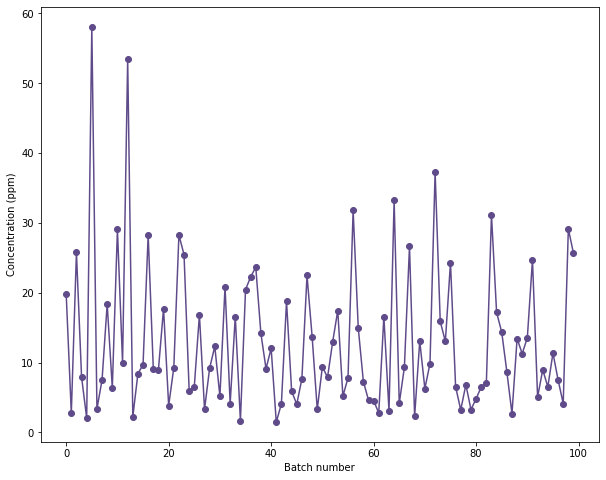

In [7]:
# make scatter plot (n.b. this won't look exactly lke in the book!)
fig, ax = plt.subplots(figsize = [10,8])
ax.plot(concentration_test_data,'o-', color = nice_purple)
ax.set_xlabel('Batch number')
ax.set_ylabel('Concentration (ppm)')
plt.show()

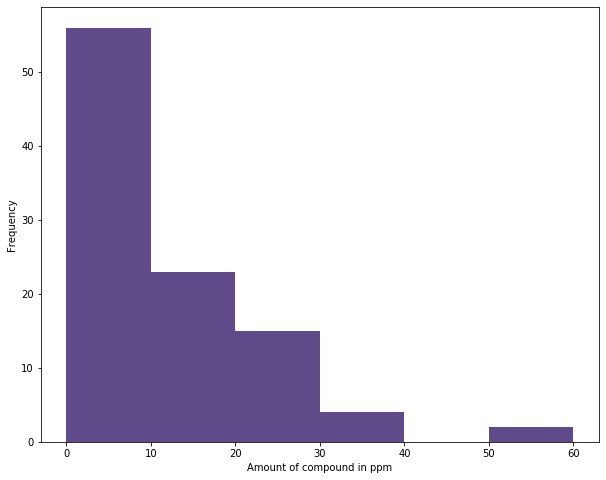

In [8]:
# make histogram
fig, ax = plt.subplots(figsize = [10,8])
ax.hist(concentration_test_data, color = nice_purple, bins = np.arange(0,70,10))
ax.set_xlabel('Amount of compound in ppm')
ax.set_ylabel('Frequency')
plt.show()

In [9]:
# Example 5.2
one_side_upper_conf_bound(0.9, concentration_test_data, 0.95)

31.294375537733927

In [10]:
# Example 5.3
one_side_upper_conf_bound(0.1, concentration_test_data, 0.95)

3.9781351364219306

In [11]:
# Example 5.4
one_side_lower_conf_bound(0.1, concentration_test_data, 0.95)

2.6005069346469982

In [12]:
# Example 5.5
one_side_lower_conf_bound(0.9, concentration_test_data, 0.95)

24.450636483977235

In [13]:
# Example 5.6
two_sided_conf_bound(0.5, concentration_test_data, 0.95)

[7.768712542438091, 12.513733454713574]

In [14]:
# Example 5.7
print(two_sided_conf_bound(0.1, concentration_test_data, 0.9))
print(two_sided_conf_bound(0.1, concentration_test_data, 0.95))

[2.6005069346469982, 3.9781351364219306]
[2.305223820975737, 4.078593058195633]


In [15]:
# Example 5.8
print(two_sided_conf_bound(0.9, concentration_test_data, 0.9))
print(two_sided_conf_bound(0.9, concentration_test_data, 0.95))

[24.450636483977235, 31.294375537733927]
[23.812853020178512, 31.803738908816854]


In [16]:
# Example 5.9
two_sided_tol_intrvls(0.9, concentration_test_data, 0.95)

Confidence bound = 0.976 (desired = 0.95)


[1.66, 37.32]

In [17]:
# Example 5.10
two_sided_interp_tol_intrvls(0.9, concentration_test_data, 0.95)

[1.9905918374677944, 39.774014098445704]

In [18]:
two_sided_conf_bound(0.5, candc_ratings,0.95)

[4.012707236871176, 4.9987866493998006]

In [19]:
two_sided_conf_bound(0.5, oeuf_ratings,0.95)

[4.33626373626374, 4.924907247093742]

In [20]:
two_sided_conf_bound(0.5, lilcol_ratings,0.95)

Lower conf bound interpolation not possible


[5, 4.999748715561946]

### Erlang distirbution